/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


(66474, 10)
         chr      start        end            1     2  3        4          5  \
201008  chr1  100027916  100029541  Peak_168774   375  .  3.46597   37.52287   
201009  chr1  100027916  100029541  Peak_212397   247  .  2.93255   24.75966   
201010  chr1  100027916  100029541  Peak_231027   212  .  2.75187   21.27480   
201011  chr1  100027916  100029541  Peak_240800   198  .  2.67162   19.80458   
201012  chr1  100027916  100029541   Peak_64424  1000  .  8.38628  201.28123   

                6  summit  
201008   35.56670    1291  
201009   22.90134      89  
201010   19.45153     688  
201011   17.99839     479  
201012  198.87112    1078  


/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
100%|██████████| 66474/66474 [00:45<00:00, 1457.95it/s]


0.40275163574942074
0.8794535656924596
0.1746188531043228


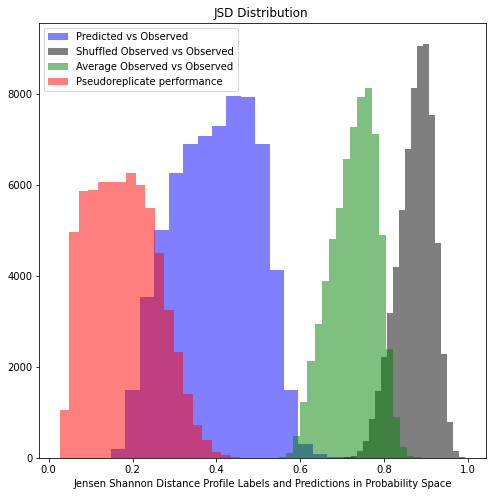

In [7]:
import h5py
import pyBigWig
import matplotlib
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm
import scipy.ndimage
import json

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


file1= "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/uncorrected_model_09.23.2024_filters_512_dil_8_fold_fold_0/uncorrected_model/hint_atac_predictions.h5" 
bigwig="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/data/K562_unstranded.bw"
rep1=pyBigWig.open("/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/data/replicates/pr1_unstranded.bw")
rep2=pyBigWig.open("/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/data/replicates/pr2_unstranded.bw")
data = h5py.File(file1)

import pandas as pd

peaks= "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/uncorrected_model_09.23.2024_filters_512_dil_8_fold_fold_0/uncorrected_model/filtered.peaks.bed" 
chr_fold_path="/mnt/lab_data2/anusri/chrombpnet/splits/fold_0.json"

NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
bed_regions=pd.read_csv(peaks,header=None,sep='\t',names=NARROWPEAK_SCHEMA)
mode="test"
splits_dict=json.load(open(chr_fold_path))
chroms_to_keep=splits_dict[mode]

bed_regions_to_keep=bed_regions[bed_regions["chr"].isin(chroms_to_keep)]
print(bed_regions_to_keep.shape)
print(bed_regions_to_keep.head())



profile_predictions = data["predictions"]["profs"].value
prof_coords_chr = data["coords"]["coords_chrom"].value
prof_coords_center = data["coords"]["coords_center"].value
prof_coords_peak = data["coords"]["coords_peak"].value
num_bins=20
plt.rcParams["figure.figsize"]=8,8


#print(prof_coords_chr.shape)
jsd_pw=[]
jsd_rnd=[]
jsd_rep=[]
jsd_ml=[]

jdx=0
bw = pyBigWig.open(bigwig) 
pseudocount=0.001

true_counts_mat = []
rep1_counts_mat = []
rep2_counts_mat = []
for idx in tqdm(range(prof_coords_chr.shape[0])):
	if prof_coords_peak[idx] == 0:
		continue

	chr = bed_regions_to_keep.iloc[jdx, 0]
	start = bed_regions_to_keep.iloc[jdx, 1] + bed_regions_to_keep.iloc[jdx, -1] - 500
	end  =  bed_regions_to_keep.iloc[jdx, 1] + bed_regions_to_keep.iloc[jdx, -1] + 500

	true_counts = np.nan_to_num(bw.values(chr,start,end ))+pseudocount
	true_counts_mat.append(true_counts)

# 	rep1_counts_mat.append(np.nan_to_num(rep1.values(chr,start,end ))+pseudocount)
#	rep2_counts_mat.append(np.nan_to_num(rep2.values(chr,start,end ))+pseudocount)
    
	rep1_counts_mat.append(np.nan_to_num(rep1.values(chr,start,end )))
	rep2_counts_mat.append(np.nan_to_num(rep2.values(chr,start,end )))

	jdx+=1


mean_profile_label=np.nanmean(true_counts_mat,axis=0)


jdx=0
for idx in tqdm(range(prof_coords_chr.shape[0])):
	if prof_coords_peak[idx] == 0:
		continue

	true_counts =  true_counts_mat[jdx]

	shuffled_labels=np.random.permutation(true_counts)
	pred_probs = profile_predictions[idx]


	#true_counts = scipy.ndimage.gaussian_filter1d(true_counts, 7,axis=0, truncate=(80 / 14))
	#pred_probs = scipy.ndimage.gaussian_filter1d(pred_probs, 7,axis=0, truncate=(80 / 14))

	#cur_jsd=jensenshannon(true_counts/(np.nansum(true_counts)),pred_probs, base=2)
	cur_jsd=jensenshannon(true_counts/(np.nansum(true_counts)+pseudocount),pred_probs, base=2)

	jsd_pw.append(cur_jsd)

	rep1_counts = rep1_counts_mat[jdx]
	rep2_counts = rep2_counts_mat[jdx]

	#mean_profile_label_prob=mean_profile_label/np.nansum(mean_profile_label)
	mean_profile_label_prob=mean_profile_label/(np.nansum(mean_profile_label)+pseudocount)

	#cur_mean_lbl=jensenshannon(true_counts/(np.nansum(true_counts)),mean_profile_label_prob, base=2)
	cur_mean_lbl=jensenshannon(true_counts/(np.nansum(true_counts)),mean_profile_label_prob, base=2)

	jsd_ml.append(cur_mean_lbl)


	#plt.figure()
	#plt.plot(true_counts/(np.nansum(true_counts)))
	#plt.plot(pred_probs)
	#plt.show()

	#shuffled_labels = scipy.ndimage.gaussian_filter1d(shuffled_labels, 7,axis=0, truncate=(80 / 14))
	#shuffled_labels_prob=shuffled_labels/(np.nansum(shuffled_labels))
	shuffled_labels_prob=shuffled_labels/(np.nansum(shuffled_labels)+pseudocount)


	rep1_counts = scipy.ndimage.gaussian_filter1d(rep1_counts, 7,axis=0, truncate=(80 / 14))
	rep2_counts = scipy.ndimage.gaussian_filter1d(rep2_counts, 7,axis=0, truncate=(80 / 14))
	#curr_jsd_rnd=jensenshannon(true_counts/(np.nansum(true_counts)),shuffled_labels_prob, base=2)
	curr_jsd_rnd=jensenshannon(true_counts/(np.nansum(true_counts)+pseudocount),shuffled_labels_prob, base=2)
	jsd_rnd.append(curr_jsd_rnd)

    

	#rep_jsd=jensenshannon(rep1_counts/(np.nansum(rep1_counts)),rep2_counts/(np.nansum(rep2_counts)), base=2)
	rep_jsd=jensenshannon(rep1_counts/(np.nansum(rep1_counts)+pseudocount),rep2_counts/(np.nansum(rep2_counts)+pseudocount), base=2)
	jsd_rep.append(rep_jsd)

	jdx+=1



print(np.nanmedian(jsd_pw))
print(np.nanmedian(jsd_rnd))
print(np.nanmedian(jsd_rep))

#print(jsd_pw)
plt.figure()
n,bins,patches=plt.hist(jsd_pw,num_bins,facecolor='blue',alpha=0.5,label="Predicted vs Observed")
n1,bins1,patches1=plt.hist(jsd_rnd,num_bins,facecolor='black',alpha=0.5,label='Shuffled Observed vs Observed')
n1,bins1,patches1=plt.hist(jsd_ml,num_bins,facecolor='green',alpha=0.5,label='Average Observed vs Observed')
n1,bins1,patches1=plt.hist(jsd_rep,num_bins,facecolor='red',alpha=0.5,label='Pseudoreplicate performance')
plt.xlabel('Jensen Shannon Distance Profile Labels and Predictions in Probability Space')
plt.title("JSD Distribution ")
plt.legend(loc='best')
plt.savefig("K562.uncorrected.jsd.plot.peaks.pdf",format='pdf',dpi=300, transparent=True)

